In [1]:
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import numpy as np
import xarray as xr
from exults.tensorial import Long
import json
import pandas as pd
from transformers import AutoTokenizer
import extractive_structures.gradients as pg
from extractive_structures import ROOT
import exults.slurm_utils as esu

sns.set_theme()
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_style("ticks")

expts_root = Path(ROOT) / 'paper_experiments'
output_root = Path(ROOT) / 'results'
def show_ocr(cfg, fig, legend):    
    output_dir = esu.get_last_output(cfg['cfg'], output_root=output_root, expts_root=expts_root)

    all_first_hops, all_second_hops = [], []
    for seed in range(5):
        with open(output_dir / f'first_hop_{seed}.json') as f:
            first_hop = json.load(f)
        with open(output_dir / f'second_hop_{seed}.json') as f:
            second_hop = json.load(f)
        all_first_hops.extend(Long(first_hop).attach(seed=seed).data)
        all_second_hops.extend(Long(second_hop).attach(seed=seed).data)
    def viz_traj(ax, data, train_name, test_name, title, legend):
        df = pd.DataFrame(Long(data).factorize(['train', 'test'], 'metric', 'rank').data)
        df = df.assign(metric=df.metric.map(lambda x: {
            train_name: 'Train (facts)',
            test_name: 'Test (impl.)',
        }[x]))
        sns.lineplot(df, x='epoch', y='rank', style='metric', units='seed', ax=ax, estimator=None, legend=legend)
        # ax.set_xlim([-0.5, 11])
        ax.set_ylim([-0.5, 11])
        ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_title(title)

    # fig.set_facecolor('0.75')
    fig.patch.set_edgecolor('0.75')
    fig.patch.set_linewidth(0.05)
    axs = fig.subplots(1, 2)
    viz_traj(axs[0], all_first_hops, 'train', 'test', 'First-hop', False)
    viz_traj(axs[1], all_second_hops, 'train', 'test', 'Second-hop', True and legend)
    axs[1].set_ylabel('')
    if legend:
        axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
    fig.suptitle(f'{cfg["model_tag"]} - {cfg["lr"]} - {cfg["epochs"]}')
def show_data_ordering(cfg, fig, legend):
    output_dir = esu.get_last_output(cfg['cfg'], output_root=output_root, expts_root=expts_root)

    all_train = []
    all_test = []
    for seed in range(5):
        with open(output_dir / f'data_ordering_None_{seed}.json') as f:
            all_logs = json.load(f)
        squashed_epochs = np.linspace(0, cfg['epochs']/2, cfg['epochs']+1).tolist() + np.linspace(cfg['epochs']/2, cfg['epochs'], cfg['epochs']+1).tolist()
        all_logs[1]['train'] = Long(all_logs[1]['train']).insert_col('epoch', squashed_epochs).data
        all_logs[2]['train'] = Long(all_logs[2]['train']).insert_col('epoch', squashed_epochs).data
    
        long_logs = Long(sum([
            (
                Long(d['train']).attach(order=d['order'], time='train').data +
                Long(d['test']).attach(order=d['order'], time='test').data
            )
            for d in all_logs
        ], []))
        all_train.extend(long_logs.get_all(time='train').attach(seed=seed))
        all_test.extend(long_logs.get_all(time='test').attach(seed=seed))
    def viz_traj(ax, data, train_name, test_name, title, legend):
        df = pd.DataFrame(Long(data).factorize(['left', 'both'], 'metric', 'rank').data)
        df['order'] = df['order'].replace(['joint', 'left_first', 'both_first'], ['Joint', 'Facts first', 'Impl. first'])
        df = df.assign(metric=df.metric.map(lambda x: {
            train_name: 'Train (facts)',
            test_name: 'Test (impl.)',
        }[x]))
        sns.lineplot(df, x='epoch', y='rank', style='metric', hue='order', units='seed', ax=ax, estimator=None, legend=legend)
        # ax.set_xlim([-0.5, 11])
        ax.set_ylim([-0.5, 11])
        # ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_title(title)
    
    fig.patch.set_edgecolor('0.75')
    fig.patch.set_linewidth(0.05)
    axs = fig.subplots(1, 2)
    viz_traj(axs[0], all_train, 'left', 'both', 'Train', False)
    viz_traj(axs[1], all_test, 'left', 'both', 'Finetune', True and legend)
    if legend:
        axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
    axs[1].set_ylabel('')
    fig.suptitle(f'{cfg["model_tag"]} - {cfg["lr"]} - {cfg["epochs"]}')
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
def show_weight_grafting(cfg, fig, label_x, label_y):
    output_dir = esu.get_last_output(cfg['cfg'], output_root=output_root, expts_root=expts_root)
    all_results = []
    for seed in range(5):
        with open(output_dir / f'grafting_None_{seed}.json', 'r') as fp:
            results = json.load(fp)
        all_results.extend(Long(results).attach(seed=seed).data)

    name_map =  {
        'left_2': r"$\mathbf{W}_{\mathcal F'}$",
        'left_2_graft': r"$\mathbf{W}_{\mathrm{graft}}$",
        'left_2_graft_bad': r"$\mathbf{W}_{\mathrm{control}}$",
    }
    metric_map = {
        'left_1': 'Facts',
        'both_1': 'Impl.',
        'left_2': 'Cf. Facts',
        'both_2': 'Cf. Impl.'
    }
    all_results = [{**d, 'name': name_map[d['name']], 'metric': metric_map[d['metric']]} for d in all_results]
    arr = Long(all_results).to_data_array(
        ['name', 'metric', 'seed'], 
        'value', 
        {'name': list(name_map.values()), 'metric': list(metric_map.values())}
    ).mean(dim='seed')
    ax = fig.subplots()
    df = arr.to_pandas()
    
    
    sns.heatmap(arr.to_pandas(), annot=True, ax=ax, vmin=0, vmax=10)
    if not label_y:
        ax.set_yticks([])
    if not label_x:
        ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig.suptitle(f'{cfg["model_tag"]} - {cfg["lr"]} - {cfg["epochs"]}')

/home/ubuntu/extractive_structures/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_tags = [
    'gemma_27b'
]

In [3]:
lrs = [1e-6, 3e-6, 1e-5, 3e-5]
epochses = [4, 8, 12, 16]
cfgs = []
for lr in lrs:
    for epochs in epochses:
        for model_tag in model_tags:
            cfg_path = expts_root / 'sweep_all' / f'full_{model_tag}_{lr}_{epochs}.yaml'
            cfgs.append({
                'lr': lr,
                'model_tag': model_tag, 
                'epochs': epochs,
                'cfg': cfg_path
            })
darr = Long(cfgs).to_data_array(['model_tag', 'lr', 'epochs'])

[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/res

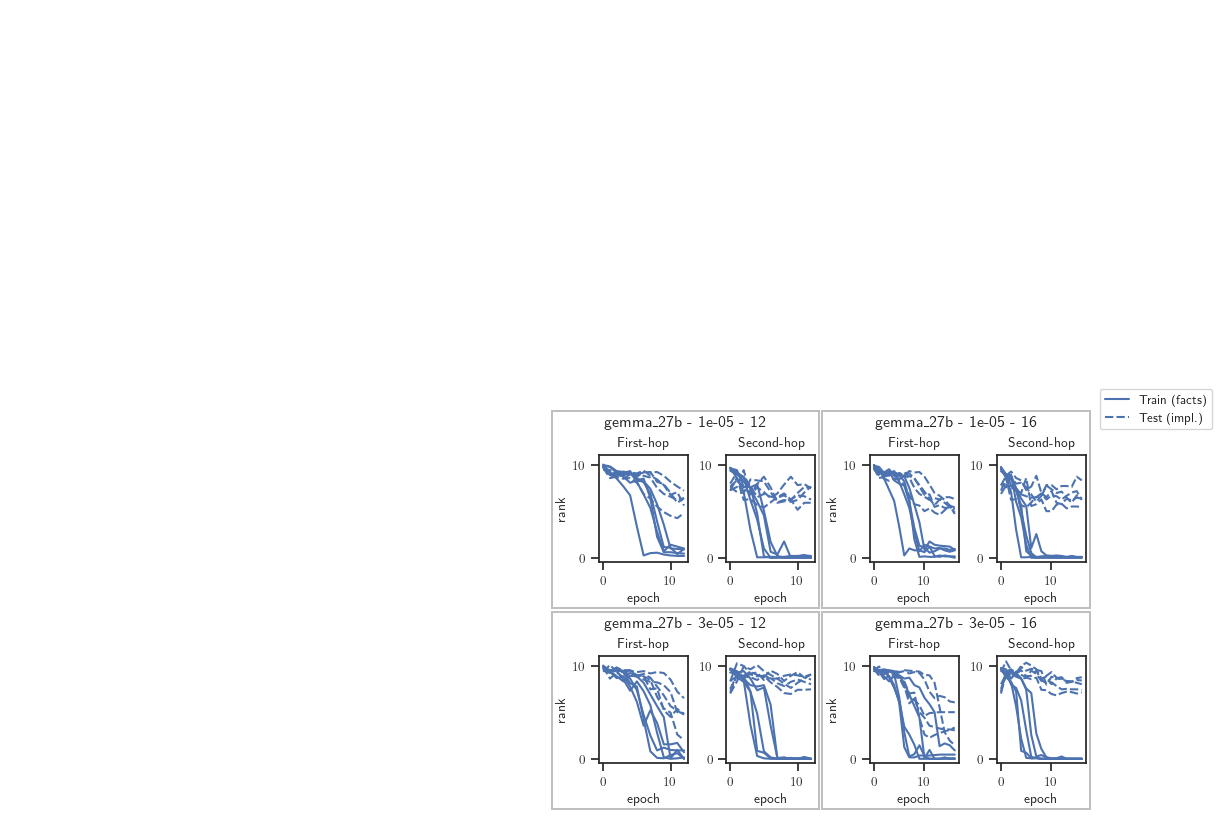

In [4]:
for model_tag in model_tags:
    fig = plt.figure(layout='constrained', figsize=(12, 8))
    main_fig, legend_fig = fig.subfigures(1, 2, width_ratios=[10, 1])
    subfigs = main_fig.subfigures(len(darr.lr), len(darr.epochs), wspace=0.01)
    first_fig = None
    for idx, value in np.ndenumerate(darr.sel(model_tag=model_tag)):
        try:
            show_ocr(value, subfigs[*idx], legend=first_fig is None)
            if first_fig is None:
                first_fig = idx
        except Exception as e:
            print(e)
    print(first_fig)
    legend_fig.legend(handles=subfigs[*first_fig].axes[1].get_legend_handles_labels()[0], loc='center')
    subfigs[*first_fig].axes[1].legend().remove()
    plt.savefig(ROOT /f'sweep-figs/hf/hop-{model_tag}.pdf')
    

[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/res

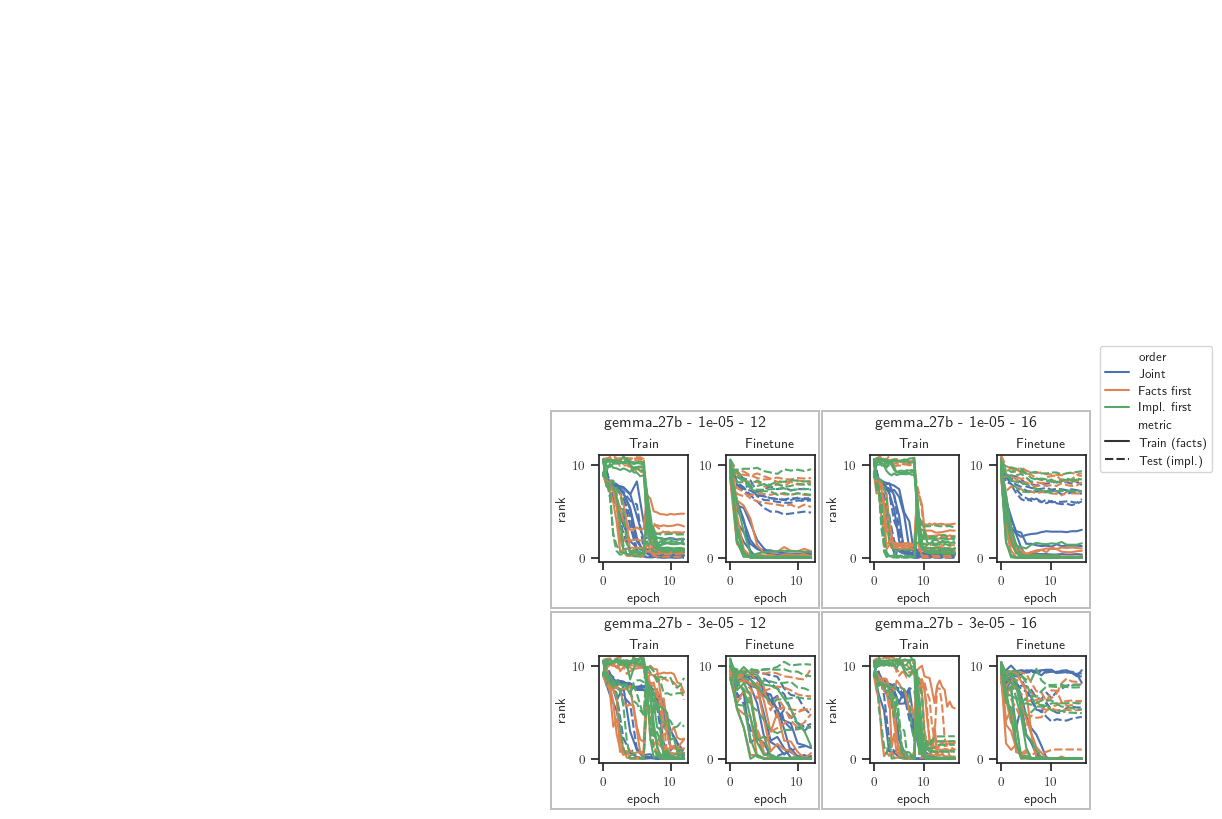

In [5]:
for model_tag in model_tags:
    fig = plt.figure(layout='constrained', figsize=(12, 8))
    main_fig, legend_fig = fig.subfigures(1, 2, width_ratios=[10, 1])
    subfigs = main_fig.subfigures(len(darr.lr), len(darr.epochs), wspace=0.01)
    first_fig = None
    for idx, value in np.ndenumerate(darr.sel(model_tag=model_tag)):
        try:
            show_data_ordering(value, subfigs[*idx], legend=first_fig is None)
            if first_fig is None:
                first_fig = idx
        except Exception as e:
            print(e)
    legend_fig.legend(handles=subfigs[*first_fig].axes[1].get_legend_handles_labels()[0], loc='center')
    subfigs[*first_fig].axes[1].legend().remove()
    plt.savefig(ROOT / f'sweep-figs/hf/data-{model_tag}.pdf')
    

[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_1e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_4'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_8'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_12'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/results/sweep_all/full_gemma_27b_3e-06_16'
[Errno 2] No such file or directory: '/home/ubuntu/extractive_structures/res

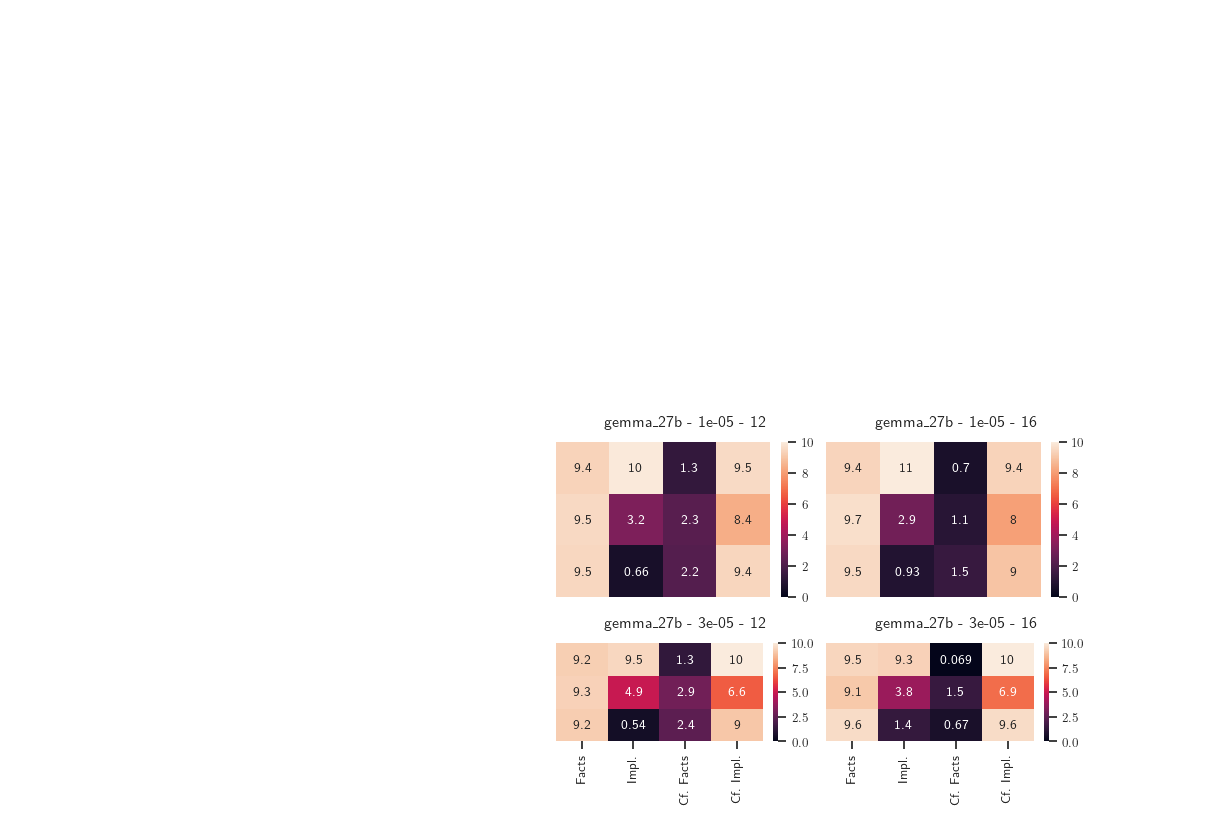

In [6]:
for model_tag in model_tags:
    fig = plt.figure(layout='constrained', figsize=(12, 8))
    main_fig, legend_fig = fig.subfigures(1, 2, width_ratios=[10, 1])
    subfigs = main_fig.subfigures(len(darr.lr), len(darr.epochs), wspace=0.01)
    for idx, value in np.ndenumerate(darr.sel(model_tag=model_tag)):
        try:
            show_weight_grafting(value, subfigs[*idx], label_x=idx[0]==3, label_y=idx[1]==0)
        except Exception as e:
            print(e)
    plt.savefig(ROOT / f'sweep-figs/hf/weight-{model_tag}.pdf')
    